In [ ]:
!pip install -q beir sentence-transformers torch numpy pandas tqdm scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 12.1 MB/s eta 0:00:00


# Download SciFact (BEIR official)

In [ ]:
import os
from beir import util

dataset = "scifact"
out_dir = "/content/beir_datasets"
data_path = util.download_and_unzip(
    url=f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip",
    out_dir=out_dir
)

print("Dataset path:", data_path)
print("Files:", os.listdir(data_path))


/content/beir_datasets/scifact.zip:   0%|          | 0.00/2.69M [00:00<?, ?iB/s]

Dataset path: /content/beir_datasets/scifact
Files: ['corpus.jsonl', 'qrels', 'queries.jsonl']


# Load corpus / queries / qrels

In [ ]:
from beir.datasets.data_loader import GenericDataLoader

corpus, queries, qrels = GenericDataLoader(data_path).load(split="test")

print("Corpus:", len(corpus))
print("Queries:", len(queries))
print("Qrels queries:", len(qrels))

# Example
first_qid = list(queries.keys())[0]
print("Example query:", queries[first_qid])
print("Example qrels:", qrels[first_qid])


  0%|          | 0/5183 [00:00<?, ?it/s]

Corpus: 5183
Queries: 300
Qrels queries: 300
Example query: 0-dimensional biomaterials show inductive properties.
Example qrels: {'31715818': 1}


# Define SBERT models

In [ ]:
SBERT_MODELS = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "MPNet": "sentence-transformers/all-mpnet-base-v2",
    "DistilRoBERTa": "sentence-transformers/all-distilroberta-v1",
}


# Evaluate each SBERT model on SciFact (nDCG/MAP/Recall/Precision)

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer

from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.models import SentenceBERT

metrics_table = []

for name, model_id in SBERT_MODELS.items():
    print(f"\n=== Evaluating: {name} | {model_id} ===")

    # Build bi-encoder
    bi_encoder = SentenceBERT(model_id)
    dres = DRES(bi_encoder, batch_size=32)

    # Retrieval + evaluator
    retriever = EvaluateRetrieval(dres, score_function="cos_sim")  # cosine similarity
    results = retriever.retrieve(corpus, queries)

    # Standard IR metrics (BEIR style)
    ndcg, _map, recall, precision = retriever.evaluate(qrels, results, retriever.k_values)

    # Keep only @10 (common + clean)
    metrics_table.append({
        "model": name,
        "nDCG@10": ndcg["NDCG@10"],
        "MAP@10": _map["MAP@10"],
        "Recall@10": recall["Recall@10"],
        "P@10": precision["P@10"],
    })

summary = pd.DataFrame(metrics_table).sort_values("nDCG@10", ascending=False)
summary



=== Evaluating: MiniLM | sentence-transformers/all-MiniLM-L6-v2 ===


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]


=== Evaluating: MPNet | sentence-transformers/all-mpnet-base-v2 ===


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]


=== Evaluating: DistilRoBERTa | sentence-transformers/all-distilroberta-v1 ===


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

,model,nDCG@10,MAP@10,Recall@10,P@10
1,MPNet,0.65570,0.60827,0.79011,0.08933
0,MiniLM,0.64508,0.59593,0.78333,0.08833
2,DistilRoBERTa,0.63146,0.57580,0.78789,0.08900


# Charts

Saved: /content/sbert_scifact_beir_results.csv


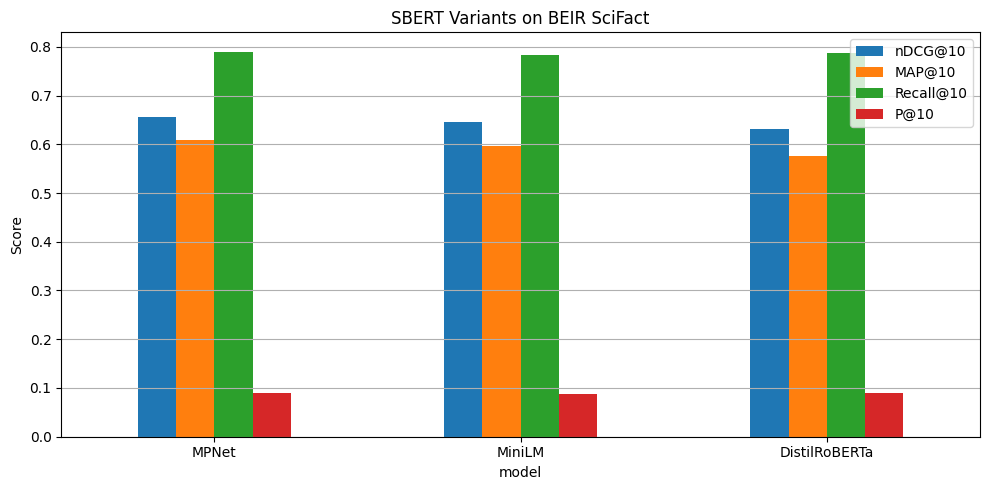

In [ ]:
import matplotlib.pyplot as plt

csv_path = "/content/sbert_scifact_beir_results.csv"
summary.to_csv(csv_path, index=False)
print("Saved:", csv_path)

ax = summary.set_index("model")[["nDCG@10", "MAP@10", "Recall@10", "P@10"]].plot(
    kind="bar", figsize=(10,5),
    title="SBERT Variants on BEIR SciFact"
)
ax.set_ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()
